# Predicting the ∆∆G of single point mutations

## The Heatmap, or Respect and Audience Again.
<center><img src="img/Slide.png"/></center>

## Introduction.

Accurately estimating the thermodynamic cost of a mutation is a building block of protein engineering and design. We will take a small protein and try to make it better. Or at least more stable. In order to achieve that, we are going to carry out "alchemical" mutations during the simulations and compute the corresponding free energy changes. If we do this both in the folded and unfolded states, and compute the difference between them, this will yield us an estimate of the difference in stability between wild type and mutant, as indicated in this thermodynamic cyclle:

<center><img src="img/cycle.png"/></center>

## Objectives
1. Setup a parameters
2. Prepare files
3. Compute the ∆∆G of mutation
4. Analyze contributions to the change in stability
5. Visualize the model in PyMOL

## Setup
The first step is to initialize __configs__ _class_ and load the protein of interest. In this tutorial, we will use .... (PDB ....). 

Mandatory class attributes:
1. __PDB_filename__ - the full (with .pdb extension) protein filename
2. __mut__ - a list of investigated mutations in Python format
3. __aa_list__ -  a list of tested mutations in each position provided in "mut" list
4. __jobname__ - a temporary folder which will contains some intermediate results

Optional class atributes (already initialized by default and mostly ogten used values):
1. __num_threads__ - number of threads, set 0 to maximum available physical cores
2. __ntraj__ - the amount of trajectories to structure relaxation before ΔΔG calc
3. __nstruct__ - the value of relaxed structures from each trajectory
4. __relax_scorefxn__ - supply a different score functon from the Rosetta default
5. __ddg_iterations__ - 
6. __force_iterations__ - if this flag is on the protocol will stop when the results converge on a score
7. __ddg_score_cutoff__ - if the lowest energy scores are within this cutoff the protocol will end early
8. __ddg_dump_pdbs__ - you can save mutants PDBs if you want
9. __ddg_bbnbrs__ - bb dof, suggestion: i-1, i, i+1
10. __fa_max_dis__ - modify fa_atr and fa_sol behavior, really important for protein stability
11. __ddg_scorefxn__ - supply a different score functon from the Rosetta default

In [5]:
!wget https://files.rcsb.org/download/2WH6.pdb

--2024-09-09 23:14:42--  https://files.rcsb.org/download/2WH6.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.245
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2WH6.pdb’

2WH6.pdb                [  <=>               ] 180.83K   765KB/s    in 0.2s    

2024-09-09 23:14:43 (765 KB/s) - ‘2WH6.pdb’ saved [185166]



In [ ]:
### Excercise 1. Extract chain B from PDB file.

#Solution:
from Bio.PDB import PDBParser, PDBIO

io = PDBIO()
pdb = PDBParser().get_structure("6CHY", "2WH6.pdb")

for chain in pdb.get_chains():
    if chain.get_id() == 'B':
        io.set_structure(chain)
        io.save(pdb.get_id() + "_" + chain.get_id() + ".pdb")

In [1]:
class configs(object):
  def __init__(self):

    self.PDB_filename = "2WH6_B.pdb" 
    self.mut = ['L12', 'I15', 'F19']#, 'V11', 'V13', 'A27', 'L37', 'V39', 'V57', 'V69', 'A71', 'F73', 'A87', 'A89', 'L99', 'V101', 'I115', 'I117']
    self.aa_list = ['A','I', 'L', 'M', 'F']#,'G','I','L','M','P','S','T','V']
    self.jobname = '2wh_chB_2' # 263
    
    self.num_threads = 0
    self.ntraj = 20
    self.nstruct = 2
    self.relax_scorefxn = 'ref2015_cart'
    self.ddg_iterations = 3
    self.force_iterations = False
    self.ddg_score_cutoff = 1.0
    self.ddg_dump_pdbs = True
    self.ddg_bbnbrs = 1
    self.fa_max_dis = 9.0
    self.ddg_scorefxn = 'ref2015_cart'
    
    import os
    if not os.path.exists(self.PDB_filename):
        raise Exception(f"Sorry, the file with name {self.PDB_filename[:-4]} was not found.")
    
    if self.num_threads == 0:
        import os 
        nslots = int(os.environ['SLURM_CPUS_PER_TASK'])
        self.num_threads = nslots
    py_flags = "-ddg:mut_file mutfile -ddg:iterations "
    py_flags += str(self.ddg_iterations) 
    py_flags += " -force_iterations "
    py_flags += str(self.force_iterations).lower()
    py_flags += " -ddg::score_cutoff "
    py_flags += str(self.ddg_score_cutoff)
    py_flags += " -ddg::cartesian -ddg::dump_pdbs "
    py_flags += str(self.ddg_dump_pdbs).lower()
    py_flags += " -ddg:bbnbrs "
    py_flags += str(self.ddg_bbnbrs)
    py_flags += " -fa_max_dis "
    py_flags += str(self.fa_max_dis)
    py_flags += " -score:weights "
    py_flags += str(self.ddg_scorefxn)
    py_flags += ".wts"
    self.py_flags = py_flags
    
    
conf = configs()

## Preparation of storage hierarchy 

At this moment the following file structure is presented:
- ddG_notebook.ipynb
- PDB_filename.pdb
- __img__
    - some illustrative images
  

## Tiny benchmark (optional)
The PDB file should be cleaned before the calculation will start.
However, let's go through tiny benchmark and look for alternative of coding via pure PyRosetta.

In [2]:
import time
import os
import datetime
from threading import Thread
n_repeats = 200

if not os.path.exists('small_benchmark'):
    os.mkdir('small_benchmark')
if not os.path.exists(f'small_benchmark/{conf.PDB_filename}'):
    os.system(f'cp {conf.PDB_filename} ./small_benchmark/{conf.PDB_filename}')
    
def pyrosetta_cleaning():
    import logging
    logging.basicConfig(filename='small_benchmark/stdout.txt', level=logging.INFO)
    import pyrosetta
    pyrosetta.init("-mute all")
    start = time.time()
    for i in range(n_repeats):
        pose = pyrosetta.pose_from_pdb(f"small_benchmark/{conf.PDB_filename}")
        pyrosetta.toolbox.cleanATOM(f"small_benchmark/{conf.PDB_filename}")
    end = time.time()
#    del logging
    import os
    duration_pyrosetta = str(end - start)
    os.system(f'echo {duration_pyrosetta} > small_benchmark/pyrosetta_cleaning.txt')
#    return end - start

def grep_cleaning():
    start = time.time()
    for i in range(n_repeats):
        os.system(f'''grep "^ATOM" small_benchmark/{conf.PDB_filename} > small_benchmark/{conf.PDB_filename[:-4]}_clean.pdb''')
    end = time.time()
    return end - start
thread = Thread(target=pyrosetta_cleaning)
thread.start()
thread.join()


duration_pyrosetta = float(open('small_benchmark/pyrosetta_cleaning.txt','r').readline())
duration_grep = grep_cleaning()

print("\n")
print('PyRosetta cleaning for ' + str(n_repeats) + \
      ' repeats: ' + "{:.2f}".format(round(duration_pyrosetta, 2)) + " seconds.")
print('bash grep cleaning for ' + str(n_repeats) + \
      ' repeats: ' +"{:.2f}".format(round(duration_grep, 2)) + " seconds.")
print("\n\t" + "Speed up = " + str(duration_pyrosetta / duration_grep) + " times")

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org


PyRosetta cleaning for 200 repeats: 37.47 seconds.
bash grep cleaning for 200 repeats: 4.26 seconds.

	Speed up = 8.793316878145317 times


## Cleaning PDB file
Let's prepare our temporary __file structure hierarchy__ and clean protein file.

In [2]:
def preparation(conf):
    name, ntraj = conf.PDB_filename, conf.ntraj
    import os
    current_dir = os.getcwd()
    if not os.path.exists(conf.jobname):
        os.mkdir(conf.jobname)
    os.chdir(conf.jobname)
    pdb_name = name[:-4]
    os.system(f'''grep "^ATOM" ../{pdb_name}.pdb > {pdb_name}_clean.pdb''')
    for i in range(1, ntraj + 1):
        
        if not os.path.exists(str(i)):
            os.mkdir(str(i))
            os.system(f'touch {str(i)}/stdout.txt')
    os.chdir(current_dir)
    return 0

preparation(conf)

0

The inner structure of __jobname__ directore is following:
- __jobname__
    - PDB_filename_clean.pdb
    - __$i^{th}$ trajectory folder__
        


## Relaxation
In the next cell we will initialize two funcitons.

The function __relax_job__ is providing relaxiation of protein structure .... EXPLANATION WITH some theory.....

def __run_relax_job_parallel__ is wrapper function for running calculation in parallel.

In [3]:
def relax_job(args):
    name_clean, nstruct, scorefxn_name, dest = args
    import os
    import logging
    current_dir = os.getcwd()
    os.chdir(dest)
    logging.basicConfig(filename='stdout.txt', level=logging.INFO)
    import pyrosetta
    pyrosetta.init()
    pose = pyrosetta.pose_from_pdb('../' + name_clean)
    scorefxn = pyrosetta.create_score_function(scorefxn_name)
    xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        <ScoreFunction name="SFX1" weights="ref2015_cart">
           <Reweight scoretype="coordinate_constraint" weight="1.0"/>
        </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
           <AtomCoordinateCstMover name="coord_cst" />
           <FastRelax name="relax" cartesian="true" scorefxn="SFX1" />
        </MOVERS>
        <APPLY_TO_POSE/>
        <PROTOCOLS>
           <Add mover="coord_cst" />
           <Add mover="relax" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")
    
    working_dir = os.getcwd()
    output_dir = dest
    jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(pdb_name=name_clean[:-4], nstruct=nstruct, scorefxn=scorefxn)
    jd.native_pose = pose
    while not jd.job_complete:
        test_pose = pose.clone()
        xml.apply(test_pose)
        jd.output_decoy(test_pose)
    os.chdir(current_dir)
    del pyrosetta
    del logging
    return 0


def run_relax_job_parallel(conf):
    name, nstruct, scorefxn_name, num_th = conf.PDB_filename, conf.nstruct, conf.relax_scorefxn, conf.num_threads
    name = name[:-4] + '_clean.pdb'
    ntraj = conf.ntraj
    from multiprocessing.pool import Pool
    import os
    os.chdir(conf.jobname)
    args = [(name, nstruct, scorefxn_name, str(i)) for i in range(1, ntraj + 1)]
    with Pool(num_th) as pool:
        pool.map(relax_job, args, chunksize=1)
    os.chdir('../')
    return 0

Now, we will run relaxiation of structure.

In [ ]:
import time
start = time.time()
run_relax_job_parallel(conf)
duration = time.time() - start
print(duration)

Inside the temporary folder, that was created at the begining we have __ntraj__ number of folders, and in each folder __nstruct__ PDBs. Additionally, there are score files with extension _*.fasc_.

- __jobname__
    - PDB_filename_clean.pdb
    - __$i^{th}$ trajectory folder__
        - stdout.txt
        - PDB_filename_*.pdb
        - PDB_filename.fasc
        


## Scoring
We have to choose the structure with the lowest energy score measured in Rosetta Energy Units (REU). 
The following function is parsing all generated _*.fasc_. score files and return __the path__ to PDB with lowest energy.

We will store the returned path as an atribute of __config class__ object.

In [5]:
def get_scores():
    import pandas as pd
    import glob
    import os
    os.chdir(conf.jobname)
    dall_scores = pd.DataFrame(columns = ['description', 'total_score'])
    for f in glob.glob('*/*.fasc'):
        pth = str(f).split('/')[0]
        with open(f, 'r') as file:
            tmp = pd.DataFrame()
            for line in file.readlines():
                total_score = float(line[line.find('total_score'):line.find('"yhh_planarity')].split(':')[1].strip()[:-1])
                name_decoy = line[line.find("decoy"):line.find(', "filename"')].split(':')[-1].split('"')[1]
                dic = {'description': [pth + '/' + name_decoy], 'total_score':[total_score]}
                tmp = pd.DataFrame(dic)
                dall_scores = pd.concat([dall_scores, tmp], ignore_index = True)

    dres = dall_scores[dall_scores.total_score == dall_scores.total_score.min()]
    source  = list(dres.description)[0]
    pdb = source.split('/')[1]
    if not os.path.exists('mutations'):
        os.mkdir('mutations')
    target = "mutations/relaxed_"  + pdb
    os.system(f'cp {source} {target}')
    return target.split('/')[-1], dall_scores.total_score.min()


conf.cleanaxed_pdb, min_REU = get_scores()
print((conf.cleanaxed_pdb, min_REU))

relaxed_Name_of_Your_Cool_Protein_clean_0.pdb


In [ ]:
### Exercise: plot scatter_plot RMSD vs total score, 
### and highlight the dot with the lowest energy

# Solution
import numpy as np
import glob
TSs = []
RMSDs = []
for file in glob.glob(f'{conf.jobname}/*/*.fasc'):
    with open(file, 'r') as fasc:
        for line in fasc.readlines():
            rmsd = float(line[line.find('rmsd'):-2].split(':')[-1])
            total_score = float(line[line.find('total_score'):line.find('"yhh_planarity')].split(':')[1].strip()[:-1])
            TSs += [total_score]
            RMSDs += [rmsd]
TSs = np.array(TSs)
RMSDs = np.array(RMSDs)

colors = ['k'] * len(TSs)
colors[np.argmin(TSs)] = 'r'

fig,ax = plt.subplots()
ax.scatter(TSs,RMSDs,c=colors)
ax.scatter([],[],c='k',label='loweset energy score')
ax.scatter([],[],c='r',label='Other scores')
ax.legend(loc='best')


## Mutfile's preparation
From this point, we obtain the relaxed protein structure that prepared for introducing mutations and analyzing them.

Let's create a little bit more new subfolders and put __mutfile__'s for as an instruction for PyRosetta mutation script.
<br><br>

Each __mutfile__ consists the following lines:

total 1 &emsp;# this is the total number of mutations being made.
<br>
1 &emsp; &emsp;&emsp;#the number of mutations
<br>
G 1 A &emsp; # the wild-type aa, the residue number, and the mutant aa


In [8]:
import os
def mutfiles_preparation(conf):
    mut = conf.mut
    aa_list = conf.aa_list
    mutations = []
    for aa in range(0, len(mut)):
        pos = mut[aa]
        AA = mut[aa][0]
        if not os.path.exists(pos):
            os.makedirs(pos)
        for m in aa_list:
            if m != AA:
                mutation = pos+m
                mutations.append(mutation)
                if not os.path.exists(pos+"/"+mutation):
                    os.makedirs(pos+"/"+mutation)
                with open(pos+"/"+mutation+"/mutfile",'w') as mut_file:
                    mut_file.write("total 1\n")
                    mut_file.write("1\n")
                    mut_file.write("%s %d %s\n" %(AA, int(mut[aa][1:]), m))
    return 0

os.chdir('mutations')
mutfiles_preparation(conf)


0

The __jobname__ folder structure now is looking like this:

- __jobname__
    - PDB_filename_clean.pdb
    - __$i^{th}$ trajectory folder__
        - stdout.txt
        - PDB_filename_*.pdb
        - PDB_filename.fasc
    - __mutations__
        - relaxed_PDB_filename_clean_$i$.pdb
        - __$i^{th}$__ mutation folder along __mut__ array
            - __$j^{th}$__ resulted mut folder along __aa_list__
                - mutfile


## $\Delta\Delta G$ calculation
In the next cell we will initialize two funciton.

def __ddg_job__ is made for estimating $\Delta\Delta G$ per one-point mutation. 

def __run_ddg_calc_parallel__ is wrapper function for running calculation in parallel.

In [11]:
def ddg_job(args):
    pdb_name, py_flags, dest = args
    import os
    import logging
    current_dir = os.getcwd()
    os.chdir(dest)
    logging.basicConfig(filename='stdout.txt', level=logging.INFO)
    import pyrosetta
    
    pyrosetta.init(py_flags)
    pose = pyrosetta.pose_from_pdb('../../' + pdb_name)
    pyrosetta.rosetta.protocols.ddg.CartesianddG.run(pose)
    os.chdir(current_dir)
    return 0

def run_ddg_calc_parallel(conf):
    name = conf.cleanaxed_pdb
    num_th = conf.num_threads
    import glob
    args = [(name, conf.py_flags, x[:-7]) for x in glob.glob('*/*/mutfile')]
    from multiprocessing.pool import Pool
    with Pool(num_th) as pool:
        pool.map(ddg_job, args, chunksize=1)
    return 0


Now, we will run $\Delta\Delta G$ calculation for all one-point mutations that were selected in __config__ class.

In [ ]:
run_ddg_calc_parallel(conf)

Let's analyze just generated outputs. We are intrested in __mutfile.ddg__  files.

The __jobname__ folder structure now is looking like this:

- __jobname__
    - PDB_filename_clean.pdb
    - __$i^{th}$ trajectory folder__
        - stdout.txt
        - PDB_filename_*.pdb
        - PDB_filename.fasc
    - __mutations__
        - relaxed_PDB_filename_clean_$i$.pdb
        - __$i^{th}$__ mutation folder along __mut__ array
            - __$j^{th}$__ resulted mut folder along __aa_list__
                - mutfile
                - mutfile.ddg
                - stdout.txt
    
Based on the information from __mutfile.ddg__, the $\Delta\Delta G$ will be calculated as follows:

$$
\begin{align}
\Large{\Delta}{\Delta}G={\frac {\sum_{i}^{} MUT\_total\_score_{i} \\}{ddg\_iterations} }-{\frac {\sum_{i}^{} WT\_total\_score_{i} \\}{ddg\_iterations} }
\end{align}
$$


## Analyzing 
The bellow function generates __*.csv__ file in root directory with $\Delta\Delta G$ values measured in REU.

In [7]:
def analyze_ssm(conf):
    mut = conf.mut
    aa_list = conf.aa_list
    import os
    import glob
    import numpy as np

    def nice_order(aa_l):
        nice_order_for_heatmap  = ["G","P","E","D","R","K","H","Q","N","T","S","Y","W","F","M","C","I","L","V","A"]
        aa_list_for_an = nice_order_for_heatmap.copy()
        for item in nice_order_for_heatmap:
            if item not in aa_l:
                aa_list_for_an.remove(item)
        return aa_list_for_an
    aa_list = nice_order(aa_list)
    ala_scan = {}
    ssm = np.zeros([len(aa_list), len(mut)], dtype=float)
    pdb_name = conf.cleanaxed_pdb[:-4]

    for aa in range(0, len(mut)):
        pos = mut[aa]
        AA = mut[aa][0]
        for i in range(0, len(aa_list)):
            amino_acid = aa_list[i]
            if AA != amino_acid:
                mutation = mut[aa]+amino_acid
                n_WT = 0
                n_MUT = 0
                score_WT = 0
                score_MUT = 0
                with open(pos+"/"+mutation+"/mutfile.ddg", 'r') as mutfile:
                    for line in mutfile:
                        if "WT" in line:
                            score = float(line.split()[3])
                            n_WT += 1
                            score_WT += score
                        elif "MUT_" in line:
                            score = float(line.split()[3])
                            n_MUT += 1
                            score_MUT += score
                score_WT = score_WT/n_WT
                score_MUT = score_MUT/n_MUT
                ddG = score_MUT - score_WT
                ssm[i,aa] = float(ddG)


    np.savetxt("../../SSM_ddg.csv", ssm, delimiter=",")
    return 0
analyze_ssm(conf)

0

Once the *SSM_ddg.csv* file is obtained, we can finally plot heatmap and detect which mutation and where could stabilize the protein.

## Heatmap

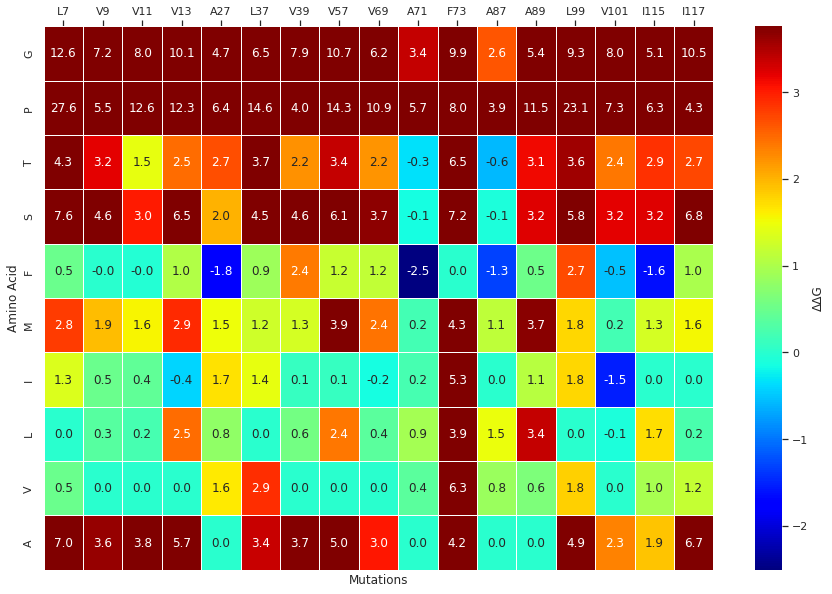

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import os
os.chdir('../../')
def plot_heatmap(conf):
    
    def nice_order(aa_l):
        nice_order_for_heatmap  = ["G","P","E","D","R","K","H","Q","N","T","S","Y","W","F","M","C","I","L","V","A"]
        aa_list_for_an = nice_order_for_heatmap.copy()
        for item in nice_order_for_heatmap:
            if item not in aa_l:
                aa_list_for_an.remove(item)
        return aa_list_for_an
    aa_list = nice_order(conf.aa_list)
    mut = conf.mut
    df_ddg = pd.read_csv('SSM_ddg.csv', header=None)    
    rows = {i:aa_list[i] for i in range(len(aa_list))}
    columns = {i:mut[i] for i in range(len(mut))}
    
    df_ddg = df_ddg.rename(columns=columns)
    df_ddg = df_ddg.rename(index=rows)
    minc = df_ddg.min().min()
    range_color = [minc, (-1.5) * minc]
    sns.set (rc = {'figure.figsize':(15, 10)})
    ax = sns.heatmap(df_ddg,  cmap="jet", annot=True, fmt=".1f",linewidth=.5, vmin = minc, vmax = (-1.5) * minc, \
                     cbar_kws={'label': 'ΔΔG', 'orientation': 'vertical'})#, annot_kws={"size": 20}
    ax.set(xlabel="Mutations", ylabel="Amino Acid")
    ax.xaxis.tick_top()
%matplotlib inline
plot_heatmap(conf)